In [3]:
from matplotlib import pyplot as plt
import FinanceDataReader as fdr
import pandas as pd

In [44]:
symbols = ['195930', # 유로스탁스 50
           '219480', # S&P 500
           '069500', # KODEX 200
           '101280', # KODEX JAPAN 
          ]

In [45]:
dfs = {}
for symbol in symbols:
    df = fdr.DataReader(symbol, '2001-06-01', '2020-06-01')
    dfs[symbol] = df
    print(symbol, "appended")

195930 appended
219480 appended
069500 appended
101280 appended


In [46]:
dfs['101280']

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2008-02-20,8660,8665,8400,8450,37448,NaN
2008-02-21,8550,8690,8450,8570,22683,0.014201
2008-02-22,8500,8570,8440,8560,6421,-0.001167
2008-02-25,8800,8820,8590,8745,14469,0.021612
2008-02-26,8950,9005,8705,8715,18733,-0.003431
...,...,...,...,...,...,...
2020-05-26,13505,13710,13505,13690,3416,0.013699
2020-05-27,13690,13895,13690,13895,2374,0.014974
2020-05-28,13970,14240,13970,14220,8269,0.023390


In [47]:
# 시작 날짜 통일
start_dates = []
for symbol, df in dfs.items():
    start_dates.append(df.index[0])
start_date = max(start_dates)
print(start_dates)

for symbol, df in dfs.items():
    dfs[symbol] = df[df.index >= start_date]
    print(symbol, dfs[symbol].index[0])

[Timestamp('2014-04-30 00:00:00'), Timestamp('2015-05-29 00:00:00'), Timestamp('2002-10-14 00:00:00'), Timestamp('2008-02-20 00:00:00')]
195930 2015-05-29 00:00:00
219480 2015-05-29 00:00:00
069500 2015-05-29 00:00:00
101280 2015-05-29 00:00:00


In [48]:
# 월별 데이터로 변환
timestamp_to_month = lambda x: x.strftime('%Y-%m')
f = {'High':'max', 'Low':'min', 'Open':'first', 'Close':'last', 'Volume':'sum'}

for symbol, df in dfs.items():
    df = df.groupby(df.index.map(timestamp_to_month)).agg(f)
    dfs[symbol] = df
    print(symbol, "converted")

195930 converted
219480 converted
069500 converted
101280 converted


In [49]:
dfs['101280'].head(3)

,High,Low,Open,Close,Volume
Date,,,,,
2015-05,11160,10990,11045,11160,926
2015-06,11100,10650,11100,10965,24828
2015-07,11630,10550,11150,11430,44632


# Backtesting

In [64]:
df_account = pd.DataFrame(index=dfs['195930'].index).reset_index()

In [65]:
df_account

,Date
0,2015-05
1,2015-06
2,2015-07
3,2015-08
4,2015-09
...,...
57,2020-02
58,2020-03
59,2020-04
60,2020-05


In [66]:
# 6개월 수익률을 월마다 구하기
WINDOW_SIZE = 6

for symbol in symbols:
    df_account[symbol] = 0.0

In [73]:
for i in range (len(df_account)):
    if i < WINDOW_SIZE:
        continue
    
    for symbol in symbols:
        now = dfs[symbol].iloc[i].Open
        past = dfs[symbol].iloc[i-WINDOW_SIZE].Open
        yield_rate = now / past
        df_account.at[i, symbol] = yield_rate

In [74]:
df_account

,Date,195930,219480,069500,101280
0,2015-05,0.000000,0.000000,0.000000,0.000000
1,2015-06,0.000000,0.000000,0.000000,0.000000
2,2015-07,0.000000,0.000000,0.000000,0.000000
3,2015-08,0.000000,0.000000,0.000000,0.000000
4,2015-09,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
57,2020-02,1.059932,1.084829,1.081356,1.087646
58,2020-03,0.983058,0.999282,1.061915,1.026792
59,2020-04,0.774906,0.853830,0.875163,0.903909
60,2020-05,0.794840,0.917732,0.932768,0.921015


In [83]:
# def get_symbol(x):
#     max_yield = -1.0
#     under_deposit_interest = True
    
#     for symbol in symbols:
#         if x[symbol] < 1.01: # 5개 EFT 중 하나라도 수익률이 마이너스이면 IEF로 선택
#             under_deposit_interest *= True
#         else:
#             under_deposit_interest *= False
            
#         if x[symbol] > max_yield:
#             max_symbol = symbol
#             max_yield = x[symbol]
            
#     if under_deposit_interest:
#         return 'CASH'
#     else:
#         return max_symbol

In [106]:
def get_symbol(x):
    max_yield = -1.0
    for symbol in symbols:
        if x[symbol] < 1.0: # 5개 EFT 중 하나라도 수익률이 마이너스이면 IEF로 선택
            return 'CASH' 
            
        if x[symbol] > max_yield:
            max_symbol = symbol
            max_yield = x[symbol]

    return max_symbol

In [107]:
df_account['SYMBOL'] = df_account.apply(lambda x: get_symbol(x), axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
df_account

,Date,195930,219480,069500,101280,SYMBOL,MUL,CUMPROD
6,2015-11,0.920796,0.979990,0.967213,0.956994,CASH,1.000000,1.000000
7,2015-12,0.974870,0.989453,0.945946,0.972973,CASH,1.000000,1.000000
8,2016-01,0.957842,0.998462,0.965707,0.979821,CASH,1.000000,1.000000
9,2016-02,0.838627,0.919880,0.971223,0.911765,CASH,1.000000,1.000000
10,2016-03,0.910355,1.025303,1.047146,0.953327,CASH,1.030988,1.030988
11,2016-04,0.943415,1.093192,1.054868,0.956055,CASH,1.011230,1.042566
12,2016-05,0.914903,0.994385,0.994085,0.955535,CASH,1.000000,1.042566
13,2016-06,0.894667,1.014213,1.004492,0.982407,CASH,0.984985,1.026912
14,2016-07,0.876006,1.017976,1.024962,0.916247,CASH,1.028968,1.056660
15,2016-08,0.991812,1.127382,1.085810,0.997556,CASH,1.000966,1.057680


In [86]:
len(df_account[df_account.SYMBOL == 'CASH']) / len(df_account)

0.3064516129032258

In [97]:
def get_multiple(x):
    symbol = x.SYMBOL
    
    if symbol == 'CASH':
        return 1.0
    
    open_price = dfs[symbol].loc[x.Date, 'Open']
    close_price = dfs[symbol].loc[x.Date, 'Close']
    return close_price / open_price

In [98]:
df_account['MUL'] = df_account.apply(lambda x: get_multiple(x), axis=1)

In [99]:
df_account

,Date,195930,219480,069500,101280,SYMBOL,MUL
0,2015-05,0.000000,0.000000,0.000000,0.000000,CASH,1.000000
1,2015-06,0.000000,0.000000,0.000000,0.000000,CASH,1.000000
2,2015-07,0.000000,0.000000,0.000000,0.000000,CASH,1.000000
3,2015-08,0.000000,0.000000,0.000000,0.000000,CASH,1.000000
4,2015-09,0.000000,0.000000,0.000000,0.000000,CASH,1.000000
...,...,...,...,...,...,...,...
57,2020-02,1.059932,1.084829,1.081356,1.087646,101280,0.922543
58,2020-03,0.983058,0.999282,1.061915,1.026792,069500,0.881456
59,2020-04,0.774906,0.853830,0.875163,0.903909,CASH,1.000000
60,2020-05,0.794840,0.917732,0.932768,0.921015,CASH,1.000000


In [100]:
df_account = df_account[WINDOW_SIZE:]

In [101]:
df_account['CUMPROD'] = df_account['MUL'].cumprod()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
df_account.tail(1)

,Date,195930,219480,069500,101280,SYMBOL,MUL,CUMPROD
61,2020-06,0.834998,0.962716,0.9806,1.000707,CASH,1.0,0.885741


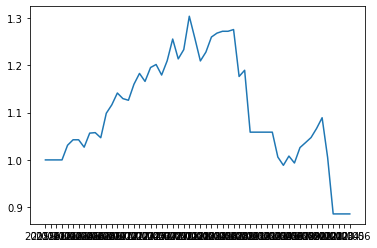

In [103]:
plt.plot(df_account['Date'], df_account['CUMPROD'])
plt.show()

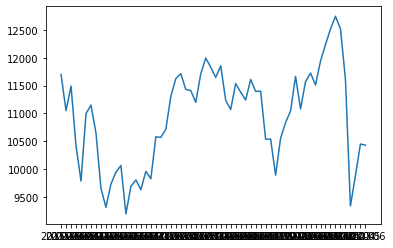

In [104]:
plt.plot(dfs['195930'].Close)
plt.show()

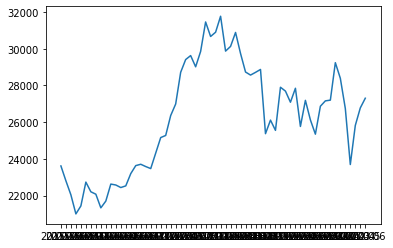

In [105]:
plt.plot(dfs['069500'].Close)
plt.show()